In [1]:
from typing import Annotated
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing_extensions import TypedDict
from langchain_core.tools import Tool
from langchain.tools import tool
from langchain_core.messages import BaseMessage
from langchain_openai import AzureChatOpenAI
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper 
from IPython.display import Image
import os 
from dotenv import load_dotenv
load_dotenv()

os.environ['AZURE_OPENAI_API_KEY'] = os.getenv('AZURE_OPENAI_API_KEY')
AZURE_API_ENDPOINT = os.getenv('AZURE_API_ENDPOINT')
AZURE_DEPLOYMENT_NAME = os.getenv('AZURE_DEPLOYMENT_NAME')
AZURE_API_VERSION = os.getenv('AZURE_API_VERSION')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = 'ReAct-Agent_v2'

/Users/kmk/Desktop/langchain/langchain/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
llm = AzureChatOpenAI(
    model='gpt-4.1-mini',
    azure_endpoint=AZURE_API_ENDPOINT,
    deployment_name=AZURE_DEPLOYMENT_NAME,
    api_version=AZURE_API_VERSION
)

In [4]:
def multiply(a:int, b:int) -> int:
    """
    Multiply a and b
    Args: 
    a: int
    b: int  
    """
    return a * b 


def add(a:int, b:int) -> int:
    """
    Add  a and b
    Args: 
    a: int
    b: int  
    """
    return a + b 

def divide(a:int, b:int) -> int:
    """
    Divide a and b
    Args: 
    a: int
    b: int  
    """
    return a / b 

In [5]:
tools = [add, multiply, divide]

In [7]:
llm_with_tools = llm.bind_tools(tools)

In [8]:
llm_with_tools

RunnableBinding(bound=AzureChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x1229aeff0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x123c71ee0>, root_client=<openai.lib.azure.AzureOpenAI object at 0x12295e600>, root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x123405d00>, model_name='gpt-4.1-mini', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True, disabled_params={'parallel_tool_calls': None}, azure_endpoint='https://cx-ct-hadoopblue-us-2-d0.openai.azure.com/', deployment_name='gpt-4.1-mini-2', openai_api_version='2024-12-01-preview', openai_api_type='azure'), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Add  a and b\nArgs: \na: int\nb: int  ', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'd

In [10]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

In [11]:
sys = SystemMessage(content='You are a helpful assistant tasked with performing arithmetic on set of inputs')

In [12]:
def assistant_node(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys] + state['messages'])]}

In [13]:
builder = StateGraph(MessagesState)

builder.add_node('ai_assistant',assistant_node)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, 'ai_assistant')
builder.add_conditional_edges(
    "ai_assistant",
    tools_condition
)
builder.add_edge('tools', 'ai_assistant')

In [14]:
memory = MemorySaver()

In [17]:
graph = builder.compile(interrupt_before=["ai_assistant"],checkpointer=memory)

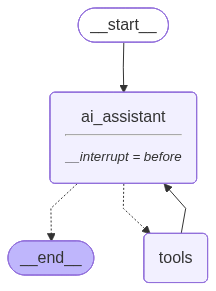

In [18]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
thread = {"configurable": {"thread_id": "1"}}

In [30]:
for event in graph.stream({"messages": [HumanMessage(content='Multiply 2 and 3')]}, config=thread, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [23]:
state = graph.get_state(thread)
state.next

('ai_assistant',)

In [25]:
graph.get_state_history(thread)

<generator object Pregel.get_state_history at 0x1243f0880>

In [32]:
for event in graph.stream(None, config=thread, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================


================================== Ai Message ==================================
Tool Calls:
  multiply (call_YsVCPNHWJ4neQjRLpxRPlNeZ)
 Call ID: call_YsVCPNHWJ4neQjRLpxRPlNeZ
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [33]:
for event in graph.stream(None, config=thread, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


#### Edit Human Feedback

In [41]:
thread = {"configurable": {"thread_id": "3"}}
for event in graph.stream({"messages": [HumanMessage(content='Multiply 2 and 3')]}, config=thread, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [42]:
state = graph.get_state(thread)

In [43]:
state.next

('ai_assistant',)

In [44]:
graph.update_state(thread, {"messages": [HumanMessage(content="No, please multiply 15 and 6")]})

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0c911f-efc5-6668-8001-2b83d24440e6'}}

In [45]:
new_state =  graph.get_state(thread)

In [46]:
new_state.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='395b7531-c10c-4054-8766-504fb846fd3a'),
  HumanMessage(content='No, please multiply 15 and 6', additional_kwargs={}, response_metadata={}, id='c9b62844-b338-4227-bcf8-4054774e0682')]}

In [47]:
for event in graph.stream(None, config=thread, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, please multiply 15 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (call_3OTtZ0Zvhr6hMKK9ZjCVMTMB)
 Call ID: call_3OTtZ0Zvhr6hMKK9ZjCVMTMB
  Args:
    a: 15
    b: 6
================================= Tool Message =================================
Name: multiply

90


In [48]:
for event in graph.stream(None, config=thread, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

90
================================== Ai Message ==================================

The result of multiplying 15 and 6 is 90.


#### Workflow will wait for user feedback

In [49]:
sys_msg = SystemMessage(content='You are an helpful assistant tasked with performing arithmetic on a set of inputs.')

In [50]:
def human_feedback(state:MessagesState):
    pass 

In [51]:
def assistant(state:MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state['messages'])]}

In [52]:
builder = StateGraph(MessagesState)

builder.add_node('assistant',assistant_node)
builder.add_node('tools', ToolNode(tools))
builder.add_node('human_feedback', human_feedback)

builder.add_edge(START, 'human_feedback')
builder.add_edge('human_feedback', 'assistant')
builder.add_conditional_edges(
    "assistant",
    tools_condition
)
builder.add_edge('tools', 'human_feedback')

In [72]:
config = {'configurable': {'thread_id':"6"}}
memory = MemorySaver()

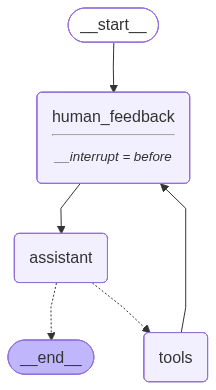

In [73]:
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [74]:
initial_input = {"messages": "multiply 2 and 3"}

In [75]:
for event in graph.stream(initial_input, config=config, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

multiply 2 and 3


In [76]:
user_input = input("Tell me how you want to update the state:")
graph.update_state(config, {"messages": user_input}, as_node='human_feedback')

for event in graph.stream(None, config=config, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

multiple 5 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (call_z7G9Zbfs2xupYKyJ3hPC4Wof)
 Call ID: call_z7G9Zbfs2xupYKyJ3hPC4Wof
  Args:
    a: 2
    b: 3
  multiply (call_XTjTJWKUCNKe6rUPVLGkDSnw)
 Call ID: call_XTjTJWKUCNKe6rUPVLGkDSnw
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: multiply

30


In [77]:
for event in graph.stream(None, config=config, stream_mode='values'):
    event['messages'][-1].pretty_print()
    

================================= Tool Message =================================
Name: multiply

30
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.
The result of multiplying 5 and 6 is 30.
